# Exp 4: Train CEFR models
This experiments aims as using EFCAMDAT to train CEFR-aligned language models.

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['CACHE_DIR'] = os.environ['FAST_CACHE_DIR'].replace("%SLURM_JOB_ID%", os.getenv('SLURM_JOB_ID')) # speed up model loading

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from tqdm.notebook import tqdm
import json
import re
import random
import xml.etree.ElementTree as ET
import datasets
from transformers import TrainingArguments, LogitsProcessor
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import LoraConfig, PeftModel
from collections import Counter
import nltk
nltk.download("punkt", download_dir=os.getenv('CACHE_DIR'))
nltk.data.path.insert(0, os.getenv('CACHE_DIR'))
from nltk.tokenize import sent_tokenize
from rouge_score import rouge_scorer

import sys
sys.path.append(f'../source')
import models
import helpers
import data

import importlib
#importlib.reload(models)

# CONFIGURATION
DATA_PATH = "../data/"
efcamdat_path = f"{DATA_PATH}EFCAMDAT_Database.xml"
preprossed_dataset_file = f"{DATA_PATH}CEFR_texts.jsonl"
dialogs_file = f"{DATA_PATH}CEFR_dialogs.json"
preprossed_dialog_file = f"{DATA_PATH}CEFR_dialogs.jsonl"
checkpoint_dir = '/cluster/home/dglandorf/models/'

2024-06-12 22:38:38.585328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.62022027.dglandorf...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.62022027.dglandorf...
[nltk_data]   Package punkt is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.62022027.dglandorf...
[nltk_data]   Package punkt is already up-to-date!


## Data Pre-Processing

Sanitize the EF-CAMDAT to be able to read it in without errors: Fix an error due to the <br> tag

In [ ]:
with open(efcamdat_path, 'r', encoding='utf-8') as file:
    file_content = file.read()
updated_content = file_content.replace('<br>', '<br />')
with open(efcamdat_path, 'w', encoding='utf-8') as file:
    file.write(updated_content)

lines_to_remove = list(range(5080477, 5080486))
with open(efcamdat_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in lines[lines_to_remove]:
    print(line)
#del lines[lines_to_remove] # remove them # CAUTION: do not execute this twice, it will remove other lines then
with open(efcamdat_path, 'w', encoding='utf-8') as file:
    file.writelines(lines)

Let's remove the corrected text from the xml file

In [145]:
def extract_uncorrected_text(element):
    """Extracts the uncorrected text from the <text> element, ignoring corrections."""
    parts = []

    if element.text:
        parts.append(element.text)
        
    for sub_elem in element:
        if sub_elem.tag == 'change':
            selection = sub_elem.find('selection')
            if selection is not None and selection.text:
                parts.append(selection.text)
            if sub_elem.tail:
                parts.append(sub_elem.tail)
        else:
            if sub_elem.text:
                parts.append(sub_elem.text)
            if sub_elem.tail:
                parts.append(sub_elem.tail)
            
    return ''.join(parts)

In [176]:
data = []
context = ET.iterparse(efcamdat_path, events=('end',))

for event, elem in tqdm(context, total=36000000):
    if elem.tag == 'writing':
        text = extract_uncorrected_text(elem.find('text'))
        data.append({
            "id": elem.get('id'),
            "text": text.strip(),
            "level": int(elem.get('level'))
        })

efcamdat = pd.DataFrame(data)

  0%|          | 0/36000000 [00:00<?, ?it/s]

Map the level to CEFR

In [178]:
grade_to_cefr = {
    range(1, 4): 'A1',
    range(4, 7): 'A2',
    range(7, 10): 'B1',
    range(10, 13): 'B2',
    range(13, 16): 'C1',
    range(16, 17): 'C2',
}

def map_grade_to_cefr(grade):
    for grade_range, cefr in grade_to_cefr.items():
        if grade in grade_range:
            return cefr
    return None
efcamdat['CEFR'] = efcamdat['level'].apply(map_grade_to_cefr)

efcamdat['CEFR'].value_counts(dropna=False)

A1    625985
A2    307995
B1    168361
B2     61329
C1     14698
C2      1940
Name: CEFR, dtype: int64

Count words per text (simply count spaces)

In [179]:
def map_text_to_num_words(text):
    return len(text.split())
    
efcamdat['num_words'] = efcamdat.text.apply(map_text_to_num_words)

In [180]:
efcamdat.groupby('CEFR').agg({"num_words": "mean"})

,num_words
CEFR,
A1,36.453861
A2,65.246595
B1,94.152660
B2,132.331393
C1,165.214315
C2,169.732990


In [181]:
efcamdat['num_words'].sum()

69640185

Convert into datasets library format

In [ ]:
if not os.path.exists(preprossed_dataset_file):
    with open(preprossed_dataset_file, 'w') as f:
        for idx, row in tqdm(efcamdat.iterrows(), total=len(efcamdat)):
            item = {
                "CEFR": row['CEFR'],
                "text": str(row['text']),
            }
            f.write(json.dumps(item) + '\n')

## Preprocess texts to dialogs

In [2]:
model, tokenizer = models.load_generator("meta-llama/Meta-Llama-3-8B-Instruct")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
# Generate dialogs with these phrases
dialogs = []
dataset = datasets.load_dataset('json', data_files=preprossed_dataset_file, split='train')
dataset = dataset.shuffle()
for item in dataset:
    print(item)
    chat_messages = tokenizer.apply_chat_template([{"role": "user", "content": f"Write a dialog using exact phrases including mistakes from this text: {item['text']}. Do not explain mistakes."}], tokenize=False, add_generation_prompt=True)
    response = models.generate(model, tokenizer, [chat_messages], max_new_tokens=256)
    dialog = [utterance.strip() for utterance in response.split("\n")]
    
    try:
        cleaned = [re.search(r'.*: (.*)', turn).group(1) for turn in dialog[1:-1] if len(turn)>3]
        print(cleaned)
        if len(cleaned):
            dialogs.append({"CEFR": item['CEFR'],
                            "writing": item['text'],
                            "dialog": cleaned})
        else:
            print(response)
    except:
        print(response)

Generating train split: 0 examples [00:00, ? examples/s]

{'CEFR': 'B2', 'text': 'This summer one friend of mine from the US visited Russia. One day we went out with our other friends. We had changed the bar and drink more and more vodka. We want to show American how we can drink. We drank as much as we can. In next bar we decided to stop drink finally. It was about 5 a.m. there. We left the bar and went outside the street. Just imagine, Saint-Petersburg, city center, old beutiful buildings. Then one our friend decided to piss on the street. He had just turned back and made his business. What the awkward situation, i was so embarassed.'}


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.89s/it]


['"This summer one friend of mine from the US visited Russia. One day we went out with our other friends. We had changed the bar and drink more and more vodka. We want to show American how we can drink. We drank as much as we can."', '"Yeah, I remember that night. We were really getting wild, weren\'t we?"', '"Yeah, we were. In next bar we decided to stop drink finally. It was about 5 a.m. there."', '"And then we left the bar and went outside the street. Just imagine, Saint-Petersburg, city center, old beutiful buildings."', '"Then one our friend decided to piss on the street. He had just turned back and made his business."', '"What the awkward situation, i was so embarassed..."', '"I know, right? I was mortified. I didn\'t know what to do."']
{'CEFR': 'B2', 'text': "It's really a pity to hear that you gonna leave this company due to your claustrophobia.You know what ? You do have a good job and great ability,it is not worth to let it destroy your life and opportunity. I don't know if 

Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.34s/it]


["It's really a pity to hear that you gonna leave this company due to your claustrophobia.", "Yeah, I'm really struggling with it. You know what? You do have a good job and great ability, it is not worth to let it destroy your life and opportunity.", "Exactly! I don't know if you ever go to see the doctor, if you don't, I think it is a good way to get some suggestion about how to control even better to resolve your problem.", "Yeah, I've been thinking about it. Actually, there is a training can let you improve your mind to a more positive and peaceful, it's call Cognitive Behavioral Therapy (CBT).", "Ah, I've heard of that! Many people have this problem just like you but have been better through this training, it might be help for you too.", "Yeah, I'm considering it. Anyway, you know I'll always be on your side."]
{'CEFR': 'A1', 'text': 'Dear Ms Thomas,There are thirteen computers and sixteen keyboards in the office. Also, there are thirty pens and fifteen pencils. There are twelve de

Generate:   0%|                                                                                                      | 0/1 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#dialogs.to_json(dialogs_file)

Read generated dialogs

In [16]:
dialogs_df = pd.read_json(dialogs_file)
len(dialogs_df)

6591

Only use turns as target that are adopted from the original writing -> Rouge-L recall

In [ ]:
scorer = rouge_scorer.RougeScorer(['rougeL'])
snippets = []
for idx, dialog in tqdm(dialogs_df.iterrows(), total=len(dialogs_df)):
    scores = [scorer.score(dialog['dialog'][i], dialog['writing'])['rougeL'][1] for i in range(1, len(dialog['dialog']))]
    if not len(scores): continue
    threshold = sorted(scores, reverse=True)[max(0, len(scores)//2-1)]
    for i in range(1, len(dialog['dialog'])):
        if scores[i-1]<threshold: continue
        snippet = {"writing": dialog['writing'],
                   "CEFR": dialog['CEFR'],
                   'context': dialog['dialog'][:i],
                   'response': dialog['dialog'][i]}
        snippets.append(snippet)

if not os.path.exists(preprossed_dialog_file) or True:
    with open(preprossed_dialog_file, 'w') as f:
        for snippet in tqdm(snippets):
            f.write(json.dumps(snippet) + '\n')

len(snippets)

# Fine-tune models to write on a certain CEFR level

## Fine-tune on dialogs

In [18]:
dataset = datasets.load_dataset('json', data_files=preprossed_dialog_file, split='train')
dataset = dataset.map(helpers.get_CEFR_prompt,
                      fn_kwargs={"apply_chat_template": tokenizer.apply_chat_template,
                                 "system_msg": False})

Map:   0%|          | 0/21289 [00:00<?, ? examples/s]

In [20]:
Counter(dataset['CEFR'])

Counter({'A1': 10371, 'A2': 6395, 'B2': 1150, 'B1': 3065, 'C2': 35, 'C1': 273})

In [24]:
item = dataset[8000]
print(item['writing'])
print(item['text'])

In the summer I prefer to wear adress and use shorts.In the winter I use blose with jeans and jacket.I like black blouse, white,green, pink ... I have almost every color.
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Only output B's response using language on CEFR level A1. This level is described as: Can interact in a simple way but communication is totally dependent on repetition at a slower rate, rephrasing and repair. Can ask and answer simple questions, initiate and respond to simple statements in areas of immediate need or on very familiar topics.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the dialog, write a possible next turn of B that an English learner on CEFR level A1 could produce:
Dialog:
A: "Hey, what do you like to wear in the summer?"
B: "In the summer I prefer to wear adress and use shorts."
A: "Adress? What's that?"
B: "Yeah, you know, adress. I like it with shorts."
A: "Hmm, I'm not sure what you mean. What do you wear in the winter?"
B: 

In [109]:
train_test_split = dataset.train_test_split(test_size=256 if len(dataset)>1024 else 0.2)
train_dataset, test_dataset = train_test_split['train'], train_test_split['test']
model_to_tune = "meta-llama/Meta-Llama-3-8B-Instruct"
output_dir = f'{checkpoint_dir}CEFR_dialogs'

## Alternative: Fine-tune on CEFR texts directly

In [9]:
dataset = datasets.load_dataset('json', data_files=preprossed_dataset_file, split='train')
level="B2"
#dataset = dataset.filter(lambda item: item['CEFR']==level) # optionally only for one level
train_test_split = dataset.train_test_split(test_size=256 if len(dataset)>1024 else 0.2)
train_dataset, test_dataset = train_test_split['train'], train_test_split['test']
model_to_tune = "meta-llama/Meta-Llama-3-8B"
output_dir = f'{checkpoint_dir}CEFR_{level}'

## Fine-tuning procedure

In [2]:
model, tokenizer = models.load_generator(model_to_tune)

NameError: name 'model_to_tune' is not defined

In [15]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM"
)

In [8]:
max_epochs = 1
batch_size = 1
grad_acc_steps = 4 // batch_size

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=1,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=grad_acc_steps,
    optim="paged_adamw_32bit",
    logging_steps=10,
    learning_rate=1e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="wandb",
    run_name="gctg",
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_eval_batch_size=batch_size,
    save_strategy="steps",
    save_steps=25,
    save_total_limit=3,
    save_only_model=True,
    #metric_for_best_model="eval_test_constraint",
    #greater_is_better=True,
    eval_accumulation_steps=1
)

In [9]:
#train_subset = datasets.Dataset.from_dict(train_dataset[0:100000])
#eval_dataset = datasets.Dataset.from_dict(test_dataset[0:64])
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=512,
    args=training_arguments,
    packing=True if not "Instruct" in model_to_tune,
    data_collator=DataCollatorForCompletionOnlyLM("<|start_header_id|>assistant<|end_header_id|>", tokenizer=tokenizer) if "Instruct" in model_to_tune else None,
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

/cluster/home/dglandorf/gctg/lib64/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [10]:
trainer.train()#f"{output_dir}/checkpoint-550")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: do-gl (domgla). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
25,2.997300,2.943759
50,2.765800,2.889825
75,2.780800,2.853077
100,2.757000,2.797309
125,2.778600,2.770574
150,2.649000,2.751113
175,2.631000,2.734101
200,2.580700,2.721258
225,2.613600,2.711160
250,2.693200,2.706330


KeyboardInterrupt: 

# Test Inference

In [2]:
model, tokenizer = models.load_generator("meta-llama/Meta-Llama-3-8B-Instruct")

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
dialog_data = data.get_dialog_data()

In [4]:
dataset = datasets.load_dataset('json', data_files=preprossed_dataset_file, split='train')

In [5]:
context, response, source, id = helpers.sample_dialog_snippet(dialog_data)
print(context)

['I do not, who?', "I don't know either. I was asking lol. I'm sure it was a scientist. All I remember was that the internet was developed by the military and wifi was developed as a byproduct when the space program was trying to improve space imaging.", "Didn't al gore say he invented it? Then he got mocked by the press and then he was actually involved with it????", 'If that is true that a shame']


## Baseline: Llama3-8B-Instruct

In [2]:
output_dir = "/cluster/scratch/dglandorf/CEFR/baseline/"
levels = ["A1", "A2", "B1", "B2"]

In [39]:
responses = {lvl: [] for lvl in levels}
for i in range(10):
    context, response, source, id = helpers.sample_dialog_snippet(dialog_data)
    for level in levels:
        print(level)
        item = {"context": context, "CEFR": level, "response": response}
        item = get_CEFR_prompt(item, apply_chat_template=tokenizer.apply_chat_template, system_msg=False)
        response = models.generate(model, tokenizer, [item['prompt']], max_new_tokens=128)
        response = helpers.parse_response(response)
        print(response)
        responses[level].append(response)

A1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Ah, yes. More holidays. And... and more money.
A2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


Ah, good question! We're thinking of adding more vacation days, flexible working hours, and a new gym membership program.
B1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Well, we're thinking of introducing flexible working hours, more paid holidays, and a gym membership program. We also want to improve our employee assistance program, which will provide support for employees dealing with personal issues.
B2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Well, for instance, we're planning to introduce flexible working hours, which will allow employees to better balance their work and personal life. Additionally, we're considering providing on-site childcare services and gym facilities to promote a healthier lifestyle.
A1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


yeah, Belfort, he go to jail.
A2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


Yeah, it's very interesting. Belfort's life is very crazy. He makes a lot of money, but he also does many bad things.
B1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Yeah, it's really interesting to see how people lived back then. And the way Belfort and Mark Hanna are portrayed is quite shocking, you know? It's like they're saying that making money is the only thing that matters.
B2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.35s/it]


Yeah, the film is really a reflection of the excesses of the 80s. The way Belfort and his colleagues lived, it's hard to believe it's true. And the way Mark Hanna, played by Crash, is portrayed is just incredible. He's this charismatic figure who teaches Belfort that the only thing that matters is making money, no matter what the cost. It's a really thought-provoking film, and I think it's one of the reasons why it's so popular.
A1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


My parents get married again?
A2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


Yeah, my mom is already seeing someone new.
B1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


Yeah, I guess that's true. But it's still hard for me to accept. I remember the fights and arguments all the time. It was like living in a war zone.
B2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Yeah, it's a relief that they're moving on, but it's still tough for me to accept. I remember how my parents used to argue all the time, and it was like living in a war zone.
A1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


Armadillos are very cool. I like their shell.
A2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


Wow, that's cool! I didn't know that. Armadillos are very special animals.
B1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.04s/it]


That's amazing! I didn't know that. I think it's cool how they can curl up into a ball for protection. Do you think they're endangered?
B2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


That's amazing! I never knew that about the name. It's no wonder they're so well-protected with that shell. I've always been fascinated by their ability to curl up into a ball for defense. Do you think they're endangered or is their population stable?
A1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Wow! Garbage dump? Fred Durst?
A2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


Ha ha, that's funny! I never knew that. Do you think it's weird to name a garbage dump after a person?
B1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]


That's crazy! I never thought about voting in space. Do you think it's fair that astronauts get to vote in elections back on Earth?
B2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


That's amazing! I never thought about voting being a global issue. I wonder if they have special voting booths for astronauts in other countries too. And haha, I can imagine Fred Durst being quite surprised to have a garbage dump named after him!
A1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


Candy Crush? I like play too!
A2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


Ah, yes! I like Candy Crush too! It's so much fun!
B1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.05s/it]


Ah, I see! I also like the camera app, it's really useful for taking photos. And Candy Crush is a great game, I've played it with my friends before. Do you play it with anyone or is it just for you?
B2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.10s/it]


Ah, I'm a big fan of games too! I've got a few puzzle games like Tetris and Sudoku that I like to play during my daily commute. And I also use the camera app to take photos of my travels. It's amazing how much technology has changed the way we live, isn't it?
A1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


They... they like Anne.
A2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


Yeah, they were nice to her. They wanted a boy, but they still took care of her.
B1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


Yeah, they were surprised at first, but they decided to keep her because they wanted a child, not a specific gender.
B2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Actually, the Cuthberts were initially disappointed, but they soon grew to love Anne as if she were their own. They were kind and patient with her, and Anne, in turn, brought a lot of energy and enthusiasm to their lives.
A1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


Um... six o'clock.
A2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


Um, I think I set it for... seven o'clock.
B1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


I set it for 7:30, but I'm not sure why I didn't hear it. Maybe it was too quiet or something.
B2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/it]


I think I set it for 7:30, but I must have forgotten to turn it off after I checked my phone.
A1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Menu... breakfast... lunch... um... both.
A2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


Um, I think it's a mix. They have some breakfast food, like eggs and pancakes, and also some lunch food, like sandwiches and salads.
B1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]


Ah, yeah, usually it's a mix of both. They have some breakfast dishes like eggs and pancakes, but also some lunch items like sandwiches and salads.
B2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Ah, yeah, usually it's a mix of both. They have a lot of eggs, pancakes, and waffles for breakfast, but also sandwiches, salads, and soups for lunch. It's a great way to try a little bit of everything.
A1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


Okay, yes.
A2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


Okay, thank you. I'll make sure he gets your message.
B1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.09s/it]


Okay, I'll make sure to pass on the message. Can you tell me what this call is about, just so I can give Mr. Potter a heads up?
B2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.20s/it]

Great, thank you. I'll make sure to pass on the message. Can you tell me a bit more about the reason for the call? What's the urgency about?


In [4]:
# you have to run this twice if there is a CUDNN version error
import stanza
from stanza.utils.conll import CoNLL
import stanza.resources.common

stanza_resources_path = os.path.join(stanza.resources.common.DEFAULT_MODEL_DIR, "resources.json")
if not os.path.isfile(stanza_resources_path):
    stanza.resources.common.download_resources_json(stanza.resources.common.DEFAULT_MODEL_DIR, stanza.resources.common.DEFAULT_RESOURCES_URL, None, stanza.resources.common.DEFAULT_RESOURCES_VERSION)
stanza_resources = json.load(open(stanza_resources_path))

lang = "english"
stanza.download(lang)
nlp = stanza.Pipeline(lang, processors="tokenize,mwt,pos,lemma,depparse")

2024-06-12 22:38:58 INFO: Downloaded file to /cluster/home/dglandorf/stanza_resources/resources.json
2024-06-12 22:38:58 INFO: "english" is an alias for "en"
2024-06-12 22:38:58 INFO: Downloading default packages for language: en (English) ...
2024-06-12 22:38:58 INFO: File exists: /cluster/home/dglandorf/stanza_resources/en/default.zip
2024-06-12 22:39:02 INFO: Finished downloading models and saved to /cluster/home/dglandorf/stanza_resources
2024-06-12 22:39:02 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-06-12 22:39:03 INFO: Downloaded file to /cluster/home/dglandorf/stanza_resources/resources.json
2024-06-12 22:39:03 INFO: "english" is an alias for "en"
2024-06-12 22:39:03 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2024-06-12 22:39:03 INFO: Using device: cuda
2024-06-12 22:39:03 INFO: Loading: tokenize
2024-06-12 22:39:03 INFO: Loading: mwt
2024-06-12 22:39:03 INFO: Loading: pos
2024-06-12 22:39:04 INFO: Loading: lemma
2024-06-12 22:39:04 INFO: Loading: depparse
2024-06-12 22:39:04 INFO: Done loading processors!


In [5]:
def calc_complexity(text, file, window=200):
    doc = nlp(text)
    CoNLL.write_doc2conll(doc, file + ".conllu")
    !txtcomplexity --lang en --preset all -i conllu --window-size {window} {file}.conllu > {file}.json

In [6]:
with open(f"{output_dir}responses.json", 'r') as outfile:
    responses = json.load(outfile)
    
for level, response in responses.items():
    print(level)
    print(len(" ".join(response).split(" ")))
    calc_complexity(" ".join(response), output_dir+level)

A1
3103
A2
6762
B1
12851
B2
18861
C1
21196
C2
27000


Calculate reference values from dialogs and essays

In [7]:
def calc_reference_scores(file, field, levels, label):
    dataset = datasets.load_dataset('json', data_files=file, split='train')
    n = len(responses["A1"])
    for level in levels:
        print(level)
        subset = dataset.filter(lambda x: x['CEFR']==level)
        print(len(subset))
        if len(subset) < n: continue
        text = " ".join(random.sample(subset[field], n))
        calc_complexity(text, output_dir+level+label)

calc_reference_scores(preprossed_dialog_file, "response", responses.keys(), "_ref")
calc_reference_scores(preprossed_dataset_file, "text", responses.keys(), "_ref_text")

A1
10371
A2
6395
B1
3065
B2
1150
C1
273
C2
35
A1
625985
A2
307995
B1
168361
B2
61329
C1
14698
C2
1940


Plot generated answers versus gold references

In [10]:
def plot_complexity(ref):
    rows = []
    def append_rows(file, level):
        stats = json.load(open(f"{file}.json", 'r'))
        metrics = stats[f"{file}.conllu"]
        for key, value in metrics.items():
            rows.append({"Level": level, "Metric": key, "Value": value['value']})
            
    for level in responses.keys():
        append_rows(f"{output_dir}{level}", level)
        if os.path.exists(f"{output_dir}{level}{ref}.json"): append_rows(f"{output_dir}{level}{ref}", f"{level}{ref}")
    
    df = pd.DataFrame(rows)
    df['Normalized Value'] = df.groupby('Metric', group_keys=False)['Value'].apply(lambda x: x - x.min())
    df['Normalized Value'] = df.groupby('Metric', group_keys=False)['Normalized Value'].apply(lambda x: x / x.max())
    
    plt.figure(figsize=(15, 8))
    ax = sns.barplot(x='Metric', y='Normalized Value', hue='Level', data=df)
    
    plt.xticks(rotation=90)
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Metrics by CEFR Level')
    plt.tight_layout()
    sns.move_legend(ax, "lower left")
    plt.show()

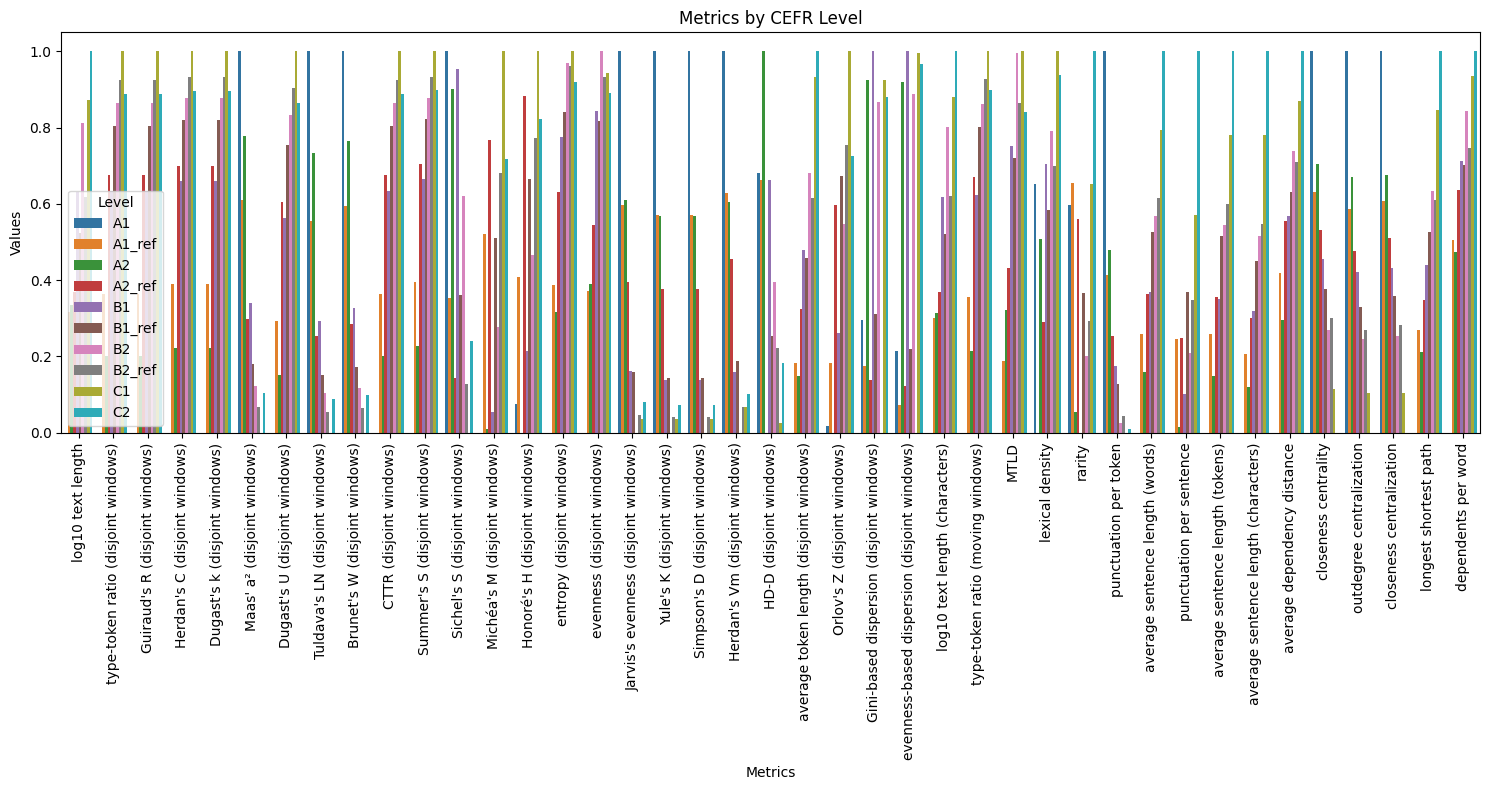

In [11]:
plot_complexity("_ref")

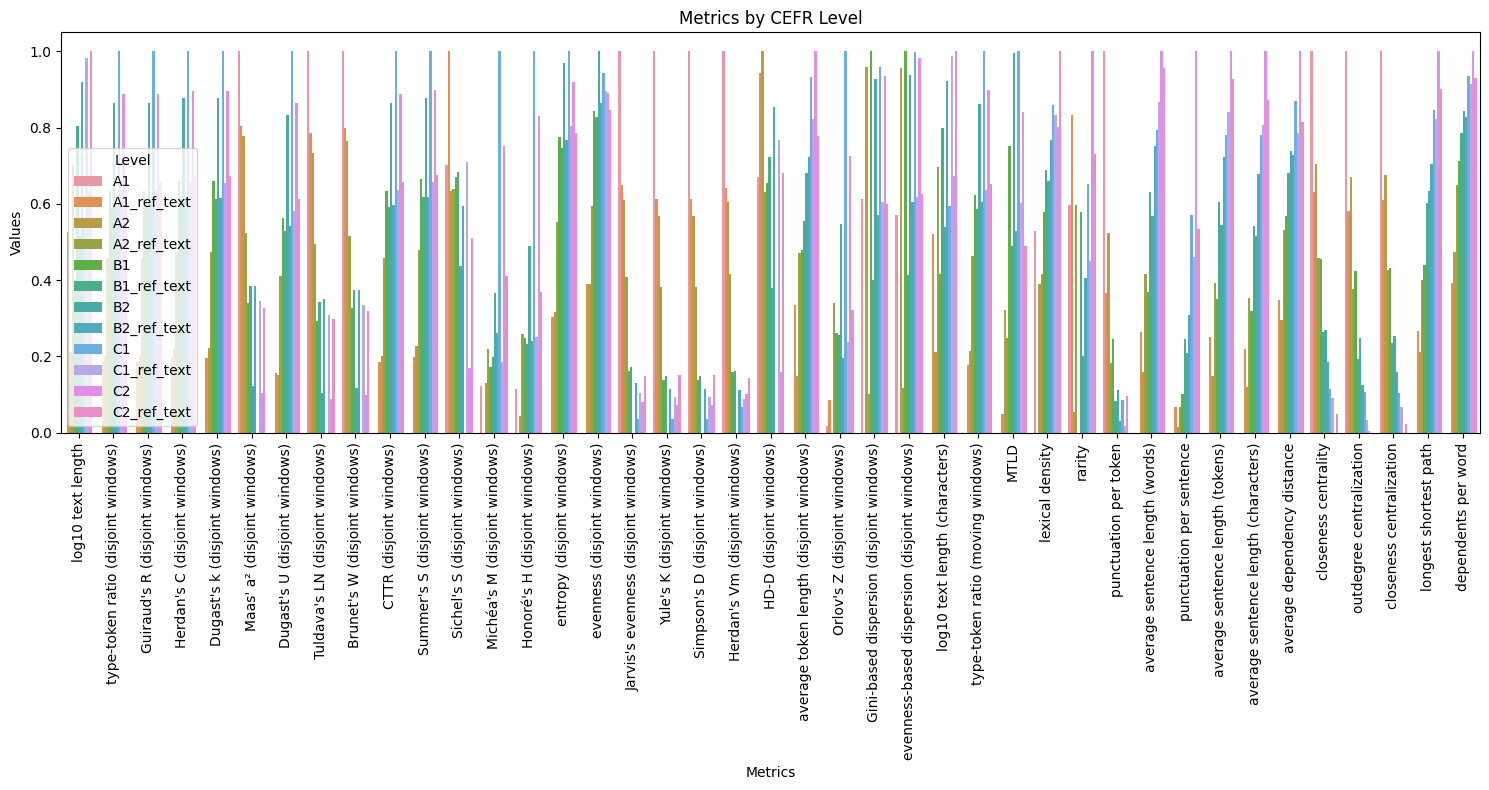

In [12]:
plot_complexity("_ref_text")

['Generated Responses' 'Reference Reponses' 'Reference Essays']


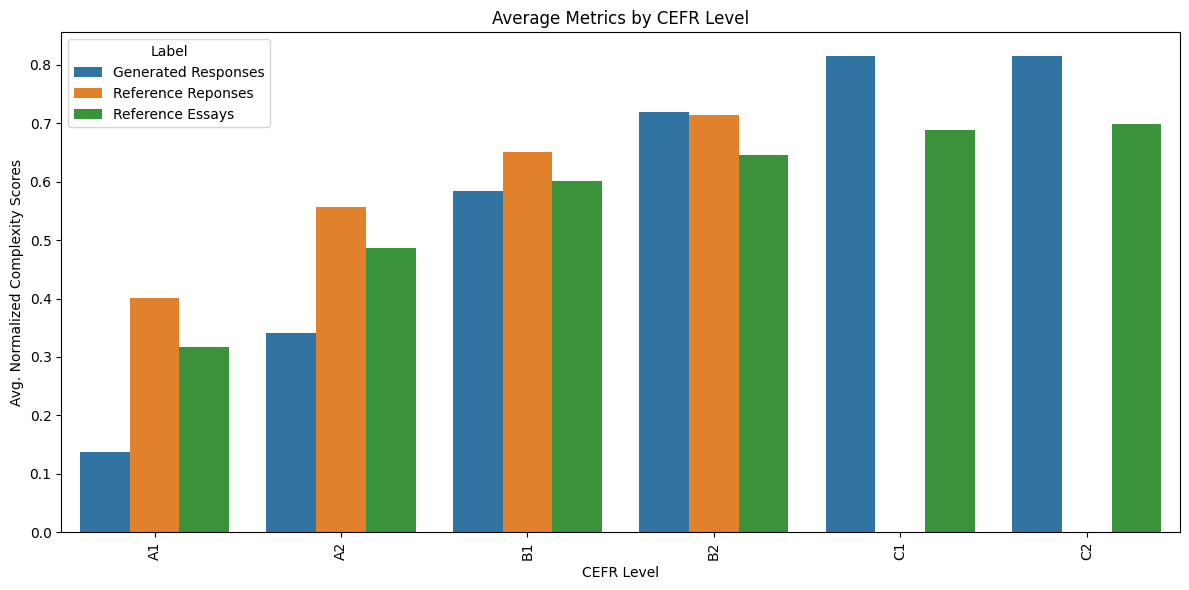

In [13]:
greater = ["log10 text length", "type-token ratio (disjoint windows)", "Guiraud's R (disjoint windows)", "Herdan's C (disjoint windows)", "Dugast's k (disjoint windows)", "Dugast's U (disjoint windows)",
           "CTTR (disjoint windows)", "Summer's S (disjoint windows)", "Honoré's H (disjoint windows)", "entropy (disjoint windows)", "evenness (disjoint windows)", "Tuldava's LN (disjoint windows)",
          "average token length (disjoint windows)", "Orlov's Z (disjoint windows)", "Gini-based dispersion (disjoint windows)", "evenness-based dispersion (disjoint windows)", "log10 text length (characters)",
          "type-token ratio (moving windows)", "average sentence length (words)", "punctuation per sentence", "average sentence length (tokens)", "average sentence length (characters)", "average dependency distance",
           "longest shortest path", "dependents per word"]


rows = []
def append_rows(output_dir, level, suffix="", label="Generated Responses"):
    file_name = output_dir + level + suffix
    stats = json.load(open(f"{file_name}.json", 'r'))
    metrics = stats[f"{file_name}.conllu"]
    for key, value in metrics.items():
        rows.append({"Label": label, "Level": level, "Metric": key, "Value": value['value'] if key in greater else 1 - value['value']})
        
for level in responses.keys():
    append_rows(output_dir, level)
    if os.path.exists(f"{output_dir}{level}_ref.json"): append_rows(output_dir, level, suffix="_ref", label="Reference Reponses")
    if os.path.exists(f"{output_dir}{level}_ref_text.json"): append_rows(output_dir, level, suffix="_ref_text", label="Reference Essays")

df = pd.DataFrame(rows)
df['Normalized Value'] = df.groupby('Metric', group_keys=False)['Value'].apply(lambda x: x - x.min())
df['Normalized Value'] = df.groupby('Metric', group_keys=False)['Normalized Value'].apply(lambda x: x / x.max())
print(df.Label.unique())
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Level", y='Normalized Value', hue="Label", data=df, errorbar=None)

plt.xticks(rotation=90)
plt.xlabel('CEFR Level')
plt.ylabel('Avg. Normalized Complexity Scores')
plt.title('Average Metrics by CEFR Level')
plt.tight_layout()
plt.show()

## Approach 1: CEFR-dialog-tuned models

In [5]:
dir = f"{checkpoint_dir}CEFR_dialog/"
model_path = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))][-1]
model.load_adapter(dir + model_path, adapter_name="dialog", device_map="auto")

In [33]:
for level in np.unique(dataset['CEFR']):
    print(level)
    item = {"context": context, "CEFR": level, "response": response}
    item = helpers.get_CEFR_prompt(item, apply_chat_template=tokenizer.apply_chat_template)
    print(models.generate(model, tokenizer, [item['prompt']], max_new_tokens=64, num_beams=3, length_penalty=10.))

A1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.39s/it]


That's impressive! Hendrix was inducted into the Rock and Roll Hall of Fame in 1992. He was also inducted into the UK Music Hall of Fame in 2005. He was posthumously awarded a Grammy Lifetime Achievement Award in 1992. He was also posthumously inducted into
A2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.25s/it]


That's impressive! Hendrix was known for his experimental and innovative playing style. He was also known for his use of feedback and distortion on his guitar. He was also known for his use of feedback and distortion on his guitar. He was also known for his use of feedback and distortion on his guitar. He was also
B1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.24s/it]


That's impressive, he was a very talented musician. He died in 1970 at the age of 27. He was a very talented musician. He died in 1970 at the age of 27. He was a very talented musician. He died in 1970 at the age of 27.
B2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.24s/it]


That's impressive, he was a very talented musician. He was known for his experimental and innovative playing style. He was also known for his ability to play the guitar with his teeth, behind his head, and between his legs. He was a true virtuoso. He was also known for his ability to play the
C1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.27s/it]


That's impressive, he was a very talented musician. He was known for his experimental and innovative playing style. He was also known for his ability to play the guitar with his teeth, behind his head, and between his legs. He was a true virtuoso. He was also known for his ability to play the
C2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.23s/it]

That's impressive, he must have been a great musician. He was inducted into the Rock and Roll Hall of Fame in 1992. He was inducted into the UK Music Hall of Fame in 2005. He was posthumously awarded the Grammy Lifetime Achievement Award in 1992. He was post


## Approach 2: CEFR-text-tuned models to guide decoding

Load finetuned models

In [50]:
model, tokenizer = models.load_generator("meta-llama/Meta-Llama-3-8B-Instruct")

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [5]:
model = models.AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct", cache_dir=os.getenv('CACHE_DIR'), device_map="sequential")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
lvl_models = {
    "A1": f"{checkpoint_dir}CEFR_A1",
    "A2": f"{checkpoint_dir}CEFR_A2",
    "B1": f"{checkpoint_dir}CEFR_B1",
    "B2": f"{checkpoint_dir}CEFR_B2"
}

In [7]:
get_path = lambda lvl: lvl_models[lvl] + "/"+ ([d for d in os.listdir(lvl_models[lvl]) if os.path.isdir(os.path.join(lvl_models[lvl], d))][-1])
cefr_model = models.AutoModelForCausalLM.from_pretrained(get_path("A1"), adapter_name="A1", cache_dir=os.getenv('CACHE_DIR'), device_map="sequential")

cefr_model.load_adapter(get_path("A2"), adapter_name="A2", device_map="sequential")
cefr_model.load_adapter(get_path("B1"), adapter_name="B1", device_map="sequential")
cefr_model.load_adapter(get_path("B2"), adapter_name="B2", device_map="sequential")

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

/cluster/home/dglandorf/gctg/lib64/python3.11/site-packages/torch/nn/modules/module.py:2025: UserWarning: for model.layers.14.self_attn.q_proj.lora_A.A1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/cluster/home/dglandorf/gctg/lib64/python3.11/site-packages/torch/nn/modules/module.py:2025: UserWarning: for model.layers.14.self_attn.q_proj.lora_B.A1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta para

RuntimeError: You can't move a model that has some modules offloaded to cpu or disk.

Check whether the loss is different for easy and hard text

In [31]:
losses = {}
dataset = dataset.shuffle()
items = []
for lvl in lvl_models.keys():
    items.append(dataset[dataset['CEFR'].index(lvl)])
    print(items[-1]['CEFR'])
    print(items[-1]['text'])

for lvl in lvl_models.keys():
    cefr_model.set_adapter(lvl)
    losses[lvl] = []
    with models.torch.no_grad():
        for item in items:
            model_input = tokenizer(item['text'], return_tensors="pt").to(models.device)
            outputs = cefr_model(**model_input, labels=model_input.input_ids)
            losses[lvl].append(outputs.loss.item())
    print(lvl)
    print(losses[lvl])

A1
Hi! My name's Kira. I'm from Russia. I live in Moscow with my parents. I'm twenty-nine.There are four people in my family: my mother, my father, my grandmother and I. I can speak Russian, French and English. I can sing. I'm  singer.Bye!
A2
Hey Dillon, thanks for e-mail! You asked me what we could do for my birthday? I can answer, that it past all what you offered for me. We could go surfing or scuba diving because both of these activities are fun and exciting or we could go sailing because it's very relaxing and on the jacht we could play the guitar and drink some wine... . In short, in the event that we, together with the girls, will be no more than ten people, then I choose the jacht. It's all! Best wishes, Alex.
B1
I went to French Italian restaurant on 14th floor with an amazing view of the city and the ocean. There were six dishes. They were not grown locally but both tasty and healthy enough. I don't mind weather they are free-fat or free range, those kind things. I was very s

In [29]:
import time

In [188]:
class CEFRLogitsProcessor(LogitsProcessor):
    def __init__(self, tokenizer, cefr_model, levels, input_len, level, alpha):
        super().__init__()
        self.tokenizer = tokenizer
        self.cefr_model = cefr_model
        self.levels = levels
        self.level = level
        self.input_len = input_len
        self.alpha = alpha

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        #print("Start processor")
        #operation_start = time.time()
        #print(self.tokenizer.batch_decode(input_ids[:,-1])[0])

        start_token_tensor = torch.tensor([[self.tokenizer.bos_token_id]], dtype=input_ids.dtype, device=models.device)
        new_input_ids = torch.cat((start_token_tensor, input_ids[:,self.input_len:]), dim=1)

        combined_logits = torch.zeros_like(scores)
        for lvl in self.levels:
            self.cefr_model.set_adapter(lvl)
            outputs = self.cefr_model(new_input_ids)
            if lvl == self.level:
                combined_logits += outputs.logits[:,-1,:]
            else:
                combined_logits -= outputs.logits[:,-1,:] / len(self.levels)

        new_scores = scores + combined_logits * self.alpha # (1 - self.alpha) * 
        #print(f"Call Logit Processor: {time.time()-operation_start}")
        new_scores[:,self.tokenizer.eos_token_id] *= 2. # overweight end of sequence
        return new_scores

def decoding(model, tokenizer, prompt, cefr_model, levels, level, do_sample=False, alpha=0.5):
    model_input = tokenizer(prompt, return_tensors="pt").to(models.device)
    input_len = model_input.input_ids.shape[1]
    kwargs = {"logits_processor": [CEFRLogitsProcessor(tokenizer, cefr_model, levels, input_len, level, alpha)],
              "renormalize_logits": True}
    
    token_ids = model.generate(**model_input,
                               max_new_tokens=128,
                               pad_token_id=tokenizer.eos_token_id,
                               eos_token_id=[tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<|end_of_text|>")],
                               do_sample=do_sample,
                               repetition_penalty=1.1,
                               temperature=1 if do_sample else None,
                               top_p=0.95 if do_sample else None,
                               top_k=300 if do_sample else None,
                               **kwargs)
    return tokenizer.batch_decode(token_ids[:,input_len:], skip_special_tokens=True)[0]

In [31]:
tokenizer = models.AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct", trust_remote_code=True, cache_dir=os.getenv('CACHE_DIR'), padding_side="right")
    

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [32]:
cefr_model.config.use_cache = True

['Why am I always the last to know these things?', "I sent out a notice. You've stopped checking your e-mail?", 'No, but Bean did send me like a hundred forwards today. My mailbox must have been overflowing.', 'How obnoxious! I heard he was sending you dirty jokes.']


In [189]:
models.torch.manual_seed(42)
results = []

for i in tqdm(range(100)):
    context, response, source, id = helpers.sample_dialog_snippet(dialog_data)
    #print(context)
    item = {"context": context, "response": response}
    item = helpers.get_generation_prompt(item, apply_chat_template=tokenizer.apply_chat_template, unconstrained=True, system_msg=True)
    text = item['prompt']
    print(text)
    
    results.append({lvl: decoding(model, tokenizer, item['prompt'], cefr_model, lvl_models.keys(), lvl, alpha=1.3) for lvl in lvl_models.keys()})
    print(results[-1])

  0%|          | 0/100 [00:00<?, ?it/s]

["I'd like to make sure my plane reservation is in order.", 'May I have your flight number, please?', 'World Airlines, Flight 201.', 'And your name, please?']
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Only output A's response.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the dialog, write a possible next turn of A.
Dialog:
A: I'd like to make sure my plane reservation is in order.
B: May I have your flight number, please?
A: World Airlines, Flight 201.
B: And your name, please?<|eot_id|><|start_header_id|>assistant<|end_header_id|>


{'A1': "I'm sorry about the weather, but you are on vacation!", 'A2': "I'm traveling as John Smith.", 'B1': "I believe that will be a one-way ticket for me, and I'll be traveling as John Smith.", 'B2': "I'd like to request a window seat if possible."}
["I'm part of the city council! Its the board that governs a city/town. Its the quickest way to become part of the government!", 'Oh cool. So you get to be a part of the decisio

In [194]:
results_file = f"{DATA_PATH}CEFR_generated.json"

In [193]:
with open(results_file, 'w') as json_file:
    json.dump(results, json_file)

In [196]:
with open(results_file, 'r', encoding='utf-8') as json_file:
    results = json.load(json_file)

In [211]:
results

[{'A1': "I'm sorry about the weather, but you are on vacation!",
  'A2': "I'm traveling as John Smith.",
  'B1': "I believe that will be a one-way ticket for me, and I'll be traveling as John Smith.",
  'B2': "I'd like to request a window seat if possible."},
 {'A1': "I can recommend the city's website or contacting the local government office to find out more information on how to establish a city council in your area.",
  'A2': "I was born in this city, so I've been working with the council for years.",
  'B1': "I think it's really important for citizens to be involved in their local government, so if you're interested in making a difference, you could look into starting a petition or attending town hall meetings to voice your opinions and concerns.",
  'B2': "I'd like to clarify what exactly the role entails and what kind of responsibilities come with being a member of the city council."},
 {'A1': "I usually go to small shops and bakeries, they're really good and not too expensive."

In [197]:
ppl = {lvl: {item_lvl: [] for item_lvl in lvl_models.keys()} for lvl in lvl_models.keys()}

for result in tqdm(results):
    for lvl in lvl_models.keys():
        cefr_model.set_adapter(lvl)
        with models.torch.no_grad():
            for item_lvl, item in result.items():
                model_input = tokenizer(item, return_tensors="pt").to(models.device)
                outputs = cefr_model(**model_input, labels=model_input.input_ids)
                ppl[lvl][item_lvl].append(outputs.loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

In [205]:
df = pd.DataFrame(ppl).applymap(np.mean)
df

,A1,A2,B1,B2
A1,2.780633,3.082479,3.026082,3.020407
A2,3.234214,2.933963,3.016983,3.048107
B1,3.284393,3.215929,2.826192,2.997070
B2,3.247457,3.196983,3.011406,2.826337


<Axes: >

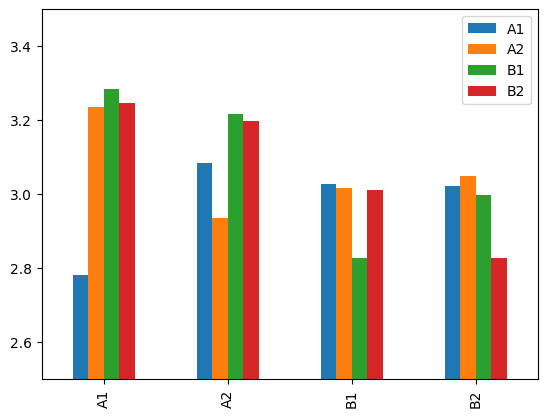

In [210]:
df.transpose().plot.bar(ylim=(2.5, 3.5))